In [134]:
# Stein Variational Gradient Descent
# Toy gaussian example
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform


In [167]:
def init_particles(N=10):
    return np.random.uniform(-1, 1, size=(N,1)) +5

def svgd_kernel(theta, h = -1):
    sq_dist = pdist(theta)
    pairwise_dists = squareform(sq_dist)**2
    if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

    # compute the rbf kernel
    Kxy = np.exp( -pairwise_dists / h**2 / 2)

    dxkxy = -np.matmul(Kxy, theta)
    sumkxy = np.sum(Kxy, axis=1)
    for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
    dxkxy = dxkxy / (h**2)
    return (Kxy, dxkxy)

def rbf_kernel_dists(diffs, h=1.0):
    return np.exp(-1.0/h * diffs*diffs)

def grad_rbf_kernel_dists(diffs, h=1.0):
    return rbf_kernel_dists(diffs, h) * (2.0/h)*diffs

def gauss_density_np(x):
    return stats.norm.pdf((x-1)*2)*0.5 + stats.norm.pdf((x+1)*2)*0.5
    #return stats.norm.pdf(x)

NORM_CONST = 1.0/np.sqrt(2*np.pi)
def grad_gauss_pdf(x):
    return NORM_CONST * np.exp(-(x*x)/2) * (-x)

def grad_gauss_density_np(x):
    g= grad_gauss_pdf((x-1)*2)*0.5 + grad_gauss_pdf((x+1)*2)*0.5
    g = g/np.linalg.norm(g) #TODO: this normalization is a hack - otherwise gradient magnitude is too small
    return g
    #return grad_gauss_pdf(x)

def update_particles(particles, alpha=0.1):
    N = particles.shape[0]
    new_particles = np.zeros_like(particles)
    
    grad_densities = np.array([grad_gauss_density_np(particles[i]) for i in range(N)])
    
    #Compute H = med^2/logn
    #diffs = particles.T - particles
    #dists = np.abs(diffs)
    #med = np.median(dists)
    #h = med*med / np.log(N)
    
    #if h>0:
    #    kernel_pairs = rbf_kernel_dists(diffs, h=h)
    #    grad_kernel_pairs = -grad_rbf_kernel_dists(diffs, h=h)
    kernel_pairs, grad_kernel_pairs = svgd_kernel(particles)
    
    g = np.matmul(kernel_pairs, grad_densities) + grad_kernel_pairs
    new_particles = particles + alpha*g
    """
    for i in range(N):
        pi = particles[i]
        g = np.zeros_like(pi)
        
        if h==0:
            g = grad_densities[i]
        else:
            for j in range(N): 
                pj = particles[j]
                kj = kernel_pairs[i, j]
                g += kj *  grad_densities[j] 
                g += grad_kernel_pairs[i, j]
            g *= 1.0/N
            

        new_particles[i] = pi + alpha*g
    """
        
    return new_particles


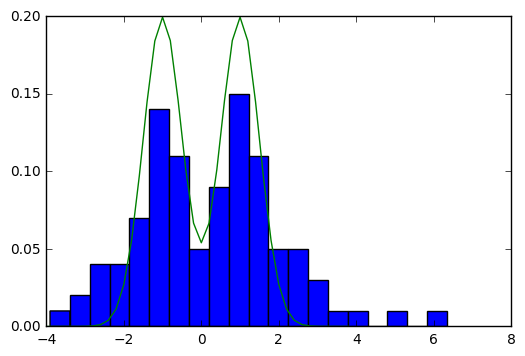

KeyboardInterrupt: 

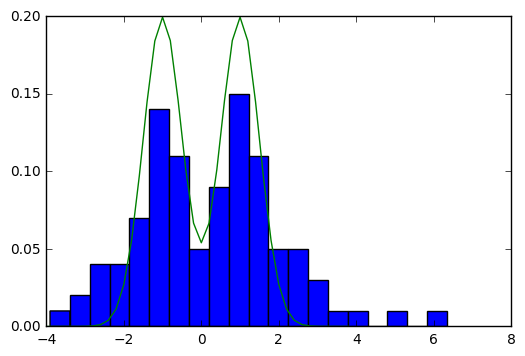

In [168]:
N=100
np.set_printoptions(suppress=True)
particles = init_particles(N)

x_plot = np.arange(-4, 4, 0.2)
densities_plot = gauss_density_np(x_plot)


for _ in range(500):
    particles = update_particles(particles, alpha=0.02)
    #print particles
    plt.clf()
    
    plt.hist(particles, weights= np.ones(N)/float(N), bins=20)
    
    #plt.scatter(particles, np.zeros_like(particles))
    plt.plot(x_plot, densities_plot)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
display.clear_output(wait=True)
